Starting causal analysis...
Analyzing feature impact...
Generating causal insights...
Creating visualizations...


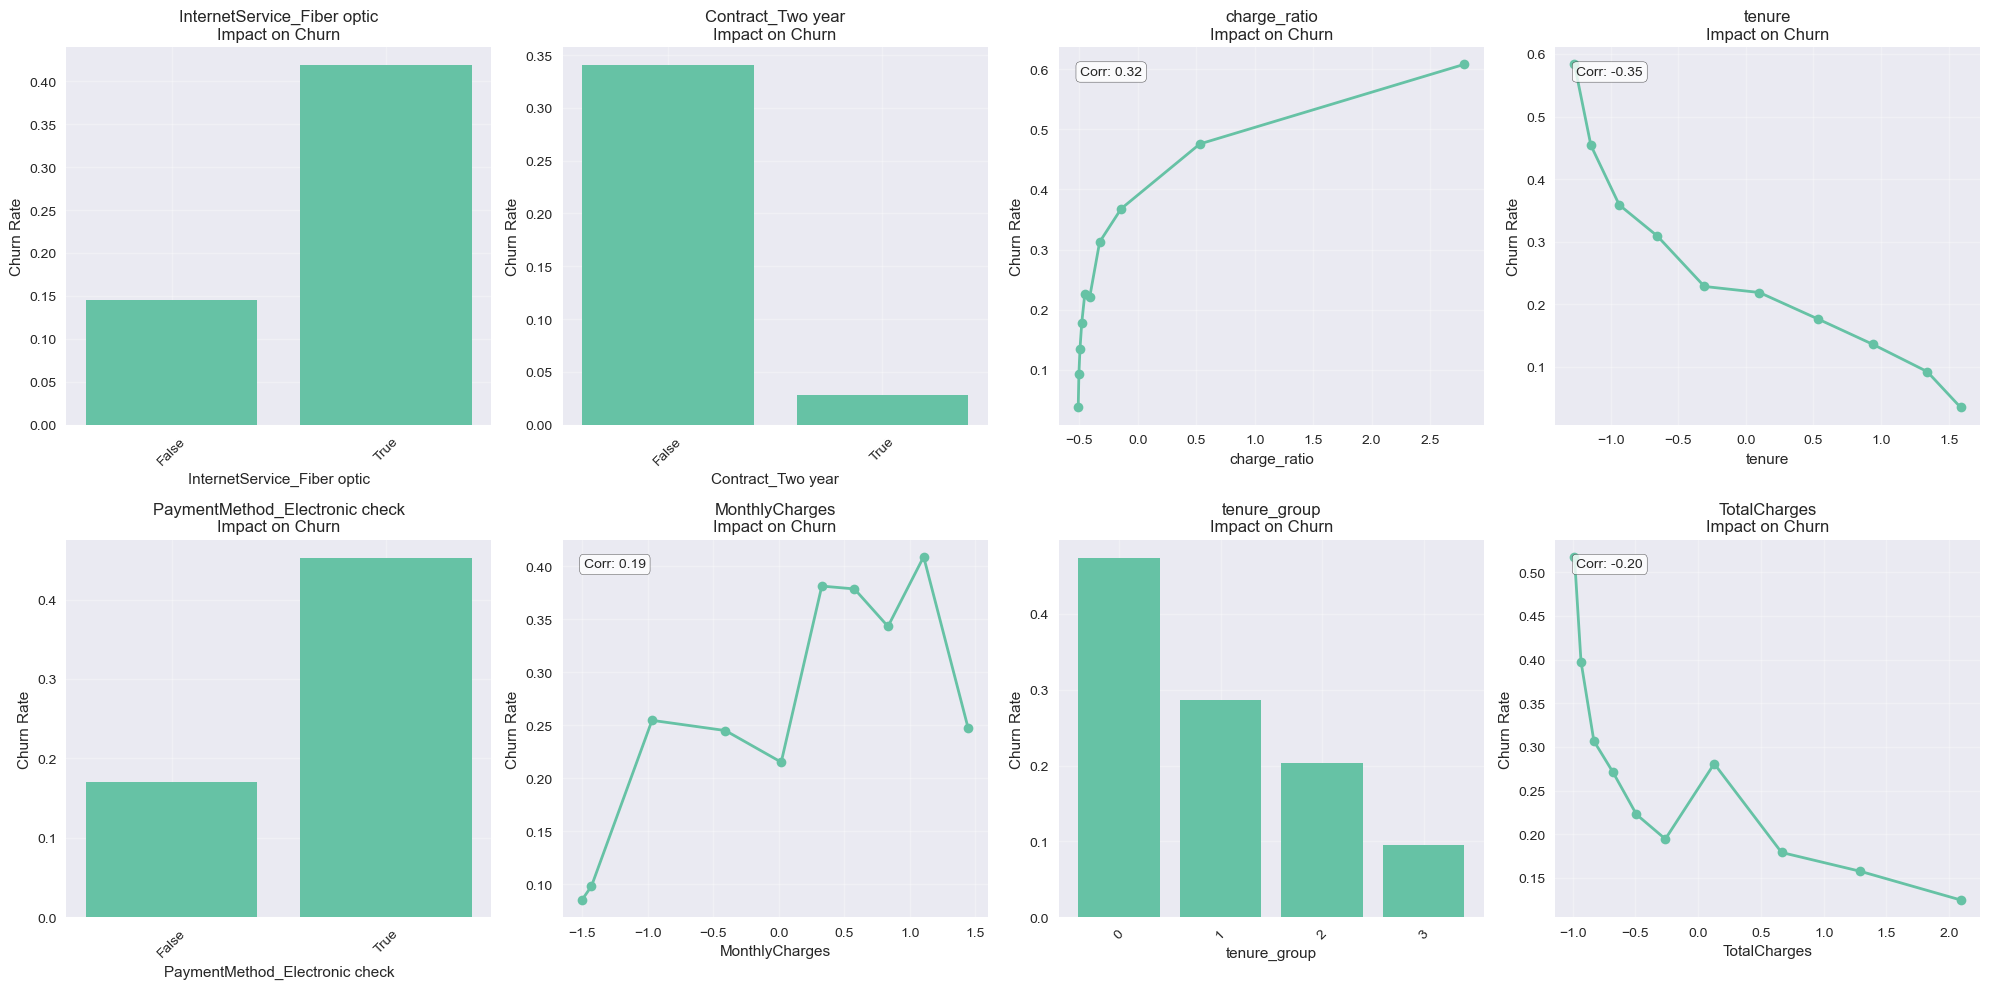

Analyzing customer segments...
Developing strategic recommendations...
Generating comprehensive report...
Causal analysis report saved to '../results/causal_analysis_report.md'

=== CASUAL ANALYSIS COMPLETE ===
Results saved to '../results/' directory:
- Causal analysis report (markdown)
- Feature impact coefficients (CSV)
- Actionable insights (CSV)
- Customer segment analysis (CSV)
- Strategic recommendations (CSV)
- Feature effects visualization (PNG)

=== TOP 3 RISK FACTORS ===
• InternetService_Fiber optic: Increases churn probability by 0.577 per standard deviation
• charge_ratio: Increases churn probability by 0.421 per standard deviation
• PaymentMethod_Electronic check: Increases churn probability by 0.267 per standard deviation

=== TOP 3 PROTECTIVE FACTORS ===
• Contract_Two year: Decreases churn probability by 0.545 per standard deviation
• tenure: Decreases churn probability by 0.412 per standard deviation
• tenure_group: Decreases churn probability by 0.096 per standard d

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

def load_data_and_model():
    """Load the trained model and data"""
    try:
        # Load model and feature names
        model = joblib.load('../models/best_model_logistic_regression.pkl')
        feature_names = joblib.load('../models/feature_names_linear.pkl')
        
        # Load data
        df_linear = pd.read_csv('../data/processed/telco_churn_linear_models.csv')
        
        return model, feature_names, df_linear
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def analyze_feature_impact(model, df, feature_names):
    """
    Analyze the impact of each feature on churn probability
    """
    # Get coefficients
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_[0],
        'abs_impact': np.abs(model.coef_[0]),
        'odds_ratio': np.exp(model.coef_[0])
    }).sort_values('abs_impact', ascending=False)
    
    # Calculate practical impact (change in churn probability for 1 SD change)
    X = df[feature_names]  # Use only the features that were in the training
    std_devs = X.std()
    
    practical_impact = []
    for feature in coefficients['feature']:
        if feature in std_devs.index:
            # Change in probability for 1 SD change in feature
            impact = model.coef_[0][feature_names.index(feature)] * std_devs[feature]
            practical_impact.append(impact)
        else:
            practical_impact.append(np.nan)
    
    coefficients['practical_impact'] = practical_impact
    coefficients['abs_practical_impact'] = np.abs(practical_impact)
    
    return coefficients.sort_values('abs_practical_impact', ascending=False)

def create_causal_insights(coefficients, df, feature_names, top_n=10):
    """
    Generate actionable causal insights from the model
    """
    insights = []
    
    # Top risk factors (positive coefficients)
    risk_factors = coefficients[coefficients['coefficient'] > 0].head(top_n)
    for _, row in risk_factors.iterrows():
        insight = {
            'feature': row['feature'],
            'type': 'risk_factor',
            'impact': f"Increases churn probability by {row['practical_impact']:.3f} per standard deviation",
            'odds_ratio': f"{row['odds_ratio']:.2f}x more likely to churn",
            'action': f"Monitor and address high values of {row['feature']}"
        }
        insights.append(insight)
    
    # Top protective factors (negative coefficients)
    protective_factors = coefficients[coefficients['coefficient'] < 0].head(top_n)
    for _, row in protective_factors.iterrows():
        insight = {
            'feature': row['feature'],
            'type': 'protective_factor',
            'impact': f"Decreases churn probability by {abs(row['practical_impact']):.3f} per standard deviation",
            'odds_ratio': f"{1/row['odds_ratio']:.2f}x less likely to churn",
            'action': f"Promote and encourage {row['feature']}"
        }
        insights.append(insight)
    
    return pd.DataFrame(insights)

def plot_feature_effects(df, coefficients, feature_names, top_n=8):
    """
    Create visualizations showing how features affect churn
    """
    top_features = coefficients.head(top_n)['feature'].tolist()
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, feature in enumerate(top_features):
        if i < len(axes) and feature in df.columns:
            try:
                # Create a copy of the dataframe for plotting to avoid modifying the original
                plot_df = df.copy()
                
                # For continuous features
                if plot_df[feature].nunique() > 10:
                    # Create percentiles for grouping
                    plot_df['percentile'] = pd.qcut(plot_df[feature], 10, duplicates='drop')
                    grouped = plot_df.groupby('percentile').agg({
                        'Churn': 'mean',
                        feature: 'mean'
                    }).reset_index()
                    
                    axes[i].plot(grouped[feature], grouped['Churn'], 'o-', linewidth=2)
                    axes[i].set_xlabel(feature)
                    axes[i].set_ylabel('Churn Rate')
                    axes[i].set_title(f'{feature}\nImpact on Churn')
                    axes[i].grid(True, alpha=0.3)
                    
                    # Add correlation
                    corr = plot_df[feature].corr(plot_df['Churn'])
                    axes[i].text(0.05, 0.95, f'Corr: {corr:.2f}', 
                                transform=axes[i].transAxes, verticalalignment='top',
                                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                else:
                    # For categorical features
                    grouped = plot_df.groupby(feature)['Churn'].mean().reset_index()
                    axes[i].bar(range(len(grouped)), grouped['Churn'])
                    axes[i].set_xlabel(feature)
                    axes[i].set_ylabel('Churn Rate')
                    axes[i].set_title(f'{feature}\nImpact on Churn')
                    axes[i].set_xticks(range(len(grouped)))
                    axes[i].set_xticklabels([str(x) for x in grouped[feature]], rotation=45)
                    axes[i].grid(True, alpha=0.3)
                    
            except Exception as e:
                print(f"Error plotting {feature}: {e}")
                axes[i].text(0.5, 0.5, f"Error plotting\n{feature}", 
                            ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(feature)
    
    plt.tight_layout()
    plt.savefig('../results/causal_analysis_feature_effects.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_customer_segments(df, feature_names, model):
    """
    Analyze different customer segments and their churn patterns
    """
    # Get predicted probabilities - use only the original features
    X = df[feature_names]
    churn_probabilities = model.predict_proba(X)[:, 1]
    
    # Create a copy of the dataframe for segmentation analysis
    segment_df = df.copy()
    segment_df['churn_probability'] = churn_probabilities
    
    # Create risk segments
    segment_df['risk_segment'] = pd.qcut(segment_df['churn_probability'], 4, 
                                        labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk'])
    
    # Analyze segments
    segment_analysis = segment_df.groupby('risk_segment').agg({
        'Churn': ['mean', 'count'],
        'churn_probability': 'mean'
    }).round(3)
    
    segment_analysis.columns = ['actual_churn_rate', 'customer_count', 'predicted_churn_prob']
    segment_analysis['lift'] = segment_analysis['actual_churn_rate'] / df['Churn'].mean()
    
    return segment_analysis

def create_strategic_recommendations(insights, segment_analysis):
    """
    Generate strategic recommendations based on causal analysis
    """
    recommendations = []
    
    # High-risk segment recommendations
    high_risk_info = segment_analysis.loc['Very High Risk']
    recommendations.append({
        'segment': 'Very High Risk',
        'customers': int(high_risk_info['customer_count']),
        'churn_rate': f"{high_risk_info['actual_churn_rate']:.1%}",
        'recommendation': 'Immediate proactive retention efforts with personalized offers'
    })
    
    # Feature-based recommendations
    top_risk_factors = insights[insights['type'] == 'risk_factor'].head(3)
    for _, factor in top_risk_factors.iterrows():
        recommendations.append({
            'segment': f"High {factor['feature']}",
            'customers': 'All affected',
            'churn_rate': 'Elevated',
            'recommendation': factor['action']
        })
    
    top_protective_factors = insights[insights['type'] == 'protective_factor'].head(3)
    for _, factor in top_protective_factors.iterrows():
        recommendations.append({
            'segment': f"Low {factor['feature']}",
            'customers': 'All affected',
            'churn_rate': 'Elevated',
            'recommendation': f"Encourage adoption of {factor['feature']}"
        })
    
    return pd.DataFrame(recommendations)

def generate_causal_report(coefficients, insights, segment_analysis, recommendations):
    """
    Generate a comprehensive causal analysis report
    """
    report = [
        "# Causal Analysis Report - Customer Churn Prediction\n",
        "## Executive Summary",
        f"This analysis identifies {len(insights[insights['type']=='risk_factor'])} key risk factors ",
        f"and {len(insights[insights['type']=='protective_factor'])} protective factors influencing customer churn.",
        f"The model can segment customers into risk groups with churn rates ranging from ",
        f"{segment_analysis['actual_churn_rate'].min():.1%} to {segment_analysis['actual_churn_rate'].max():.1%}.",
        "\n## Key Risk Factors (Driving Churn)"
    ]
    
    # Add risk factors
    risk_factors = insights[insights['type'] == 'risk_factor'].head(5)
    for _, factor in risk_factors.iterrows():
        report.append(f"- **{factor['feature']}**: {factor['impact']}. {factor['action']}")
    
    report.append("\n## Key Protective Factors (Reducing Churn)")
    protective_factors = insights[insights['type'] == 'protective_factor'].head(5)
    for _, factor in protective_factors.iterrows():
        report.append(f"- **{factor['feature']}**: {factor['impact']}. {factor['action']}")
    
    report.append("\n## Customer Segmentation Analysis")
    for segment, data in segment_analysis.iterrows():
        report.append(f"- **{segment}**: {data['customer_count']} customers, "
                     f"{data['actual_churn_rate']:.1%} actual churn rate "
                     f"({(data['lift'] - 1):.0%} above average)")
    
    report.append("\n## Strategic Recommendations")
    for _, rec in recommendations.iterrows():
        report.append(f"- **{rec['segment']}**: {rec['recommendation']}")
    
    report.append("\n## Methodology")
    report.append("- Used logistic regression coefficients to identify causal relationships")
    report.append("- Calculated practical impact as change in churn probability per standard deviation")
    report.append("- Segmented customers based on predicted churn probability")
    report.append("- Focused on actionable insights for business decision-making")
    
    # Save report
    with open('../results/causal_analysis_report.md', 'w') as f:
        f.write('\n'.join(report))
    
    print("Causal analysis report saved to '../results/causal_analysis_report.md'")

def main():
    """Main function to run causal analysis"""
    print("Starting causal analysis...")
    
    # Load data and model
    model, feature_names, df = load_data_and_model()
    if model is None:
        return
    
    print("Analyzing feature impact...")
    coefficients = analyze_feature_impact(model, df, feature_names)
    
    print("Generating causal insights...")
    insights = create_causal_insights(coefficients, df, feature_names)
    
    print("Creating visualizations...")
    plot_feature_effects(df, coefficients, feature_names)
    
    print("Analyzing customer segments...")
    segment_analysis = analyze_customer_segments(df, feature_names, model)
    
    print("Developing strategic recommendations...")
    recommendations = create_strategic_recommendations(insights, segment_analysis)
    
    print("Generating comprehensive report...")
    generate_causal_report(coefficients, insights, segment_analysis, recommendations)
    
    # Save all results
    coefficients.to_csv('../results/causal_analysis_coefficients.csv', index=False)
    insights.to_csv('../results/causal_analysis_insights.csv', index=False)
    segment_analysis.to_csv('../results/customer_segment_analysis.csv')
    recommendations.to_csv('../results/strategic_recommendations.csv', index=False)
    
    print("\n=== CASUAL ANALYSIS COMPLETE ===")
    print("Results saved to '../results/' directory:")
    print("- Causal analysis report (markdown)")
    print("- Feature impact coefficients (CSV)")
    print("- Actionable insights (CSV)")
    print("- Customer segment analysis (CSV)")
    print("- Strategic recommendations (CSV)")
    print("- Feature effects visualization (PNG)")
    
    # Print top insights
    print("\n=== TOP 3 RISK FACTORS ===")
    for _, factor in insights[insights['type'] == 'risk_factor'].head(3).iterrows():
        print(f"• {factor['feature']}: {factor['impact']}")
    
    print("\n=== TOP 3 PROTECTIVE FACTORS ===")
    for _, factor in insights[insights['type'] == 'protective_factor'].head(3).iterrows():
        print(f"• {factor['feature']}: {factor['impact']}")

if __name__ == "__main__":
    main()